In [1]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision import datasets
import torchvision.transforms.v2 as v2

data preprocessing and exploration

In [21]:
train_path = '../input/seg_train'
test_path = '../input/seg_test'
# pred_path = '../input/seg_pred'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# classes that we have now, total 6
class_num = len(os.listdir(train_path))
print('Classes :' , os.listdir(train_path))
print('class_num :', class_num)


Classes : ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_num : 6


<BarContainer object of 6 artists>

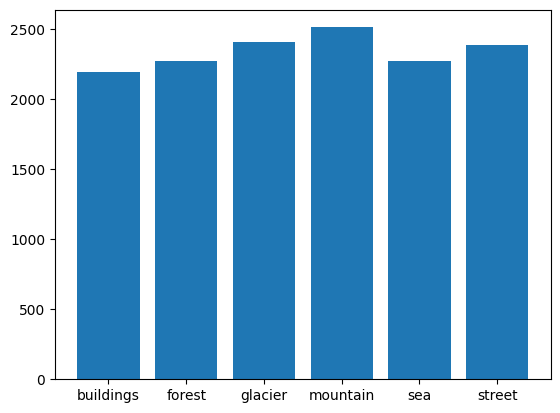

In [4]:
# use df to count how many images are in each class
class_count = {}
for class_name in os.listdir(train_path):
    class_path  = os.path.join(train_path, class_name)
    class_count[class_name] = len(os.listdir(class_path))
    
category = list(class_count.keys())
count = list(class_count.values())

plt.bar(category, count)
# so now we can see, there is no class imbalance problem in this dataset, so no need to work on the weights

In [5]:
# Load the image using OpenCV
image_path = os.path.join(train_path, 'sea/97.jpg')
image = cv2.imread(image_path)

# Convert the image to a NumPy array
image_np = np.array(image)

# Display the shape of the NumPy array
print(image_np.shape, '= (height, width, channels)')

(150, 150, 3) = (height, width, channels)


prepare data using datasets.ImageFolder

In [6]:
w, h = 150 ,150

In [7]:
transform = v2.Compose([
    v2.RandomResizedCrop(size=(w,h), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [8]:
# use ImageFolder to load data
# will automatically change the shape from jpg(150,150,3) to dataset tensor(3,150,150)
train_data = datasets.ImageFolder(root=train_path, transform=transform)
test_data = datasets.ImageFolder(root=test_path, transform=transform)

In [9]:
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.imgs[:5]) # dir and label idx

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
[('../input/seg_train\\buildings\\0.jpg', 0), ('../input/seg_train\\buildings\\10006.jpg', 0), ('../input/seg_train\\buildings\\1001.jpg', 0), ('../input/seg_train\\buildings\\10014.jpg', 0), ('../input/seg_train\\buildings\\10018.jpg', 0)]


In [10]:
train_data[0][0].shape

torch.Size([3, 150, 150])

build model

In [11]:
# create a simple CNN model, since there are only 6 class, and features are not that complex
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # this is a simple CNN, just write together to save time
        self.conv = nn.Sequential(
            nn.Conv2d(3, 200, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(200, 180, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(5,5),
            
            nn.Conv2d(180, 140, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(140, 100, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(5,5),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(180),
            nn.ReLU(),
            nn.Linear(180, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(50, num_classes),
        )
        
        

    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x
        
    
model = CNN(class_num)
print(model)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(200, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(180, 140, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(140, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=180, bias=True)
    (2): ReLU()
    (3): Linear(in_features=180, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=50, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=50, out_features=6, bias=True)
  )
)


func for train and test loop

In [12]:
def acc_fn(x, y):
    # Calculate the number of correct matches
    correct_matches = torch.sum(x == y).item()

    # Calculate the total number of elements
    total_elements = x.numel()

    # Calculate the accuracy percentage
    accuracy = correct_matches / total_elements

    return accuracy

In [13]:
from tqdm.auto import tqdm
def train_loop(model, train_dataloader, test_dataloader, loss_fn, optimizer, device, epochs, scheduler=None):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
    model.to(device)
    # acc_fn.to(device)
    
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    
    for epoch in range(epochs):
        # train
        train_loss, train_acc = 0, 0
        model.train()
        
        for (X, y) in tqdm(train_dataloader):
            # X = torch.tensor(X, dtype=torch.float32)
            pred = model(X.to(device))
            loss = loss_fn(pred, y.to(device))
            train_loss += loss.item()
            train_acc += acc_fn(pred.argmax(dim=1), y.to(device))
            # print(pred.argmax(dim=1), y)
            
            # backprop
            loss.backward() # compute gradients using para and loss fn
            optimizer.step() # update para using computed gradients above
            optimizer.zero_grad() # reset gradients for next iteration
            
        # avg train acc, loss
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # test
        test_loss, test_acc = 0, 0
        model.eval()
        for (X, y) in tqdm(test_dataloader):
            # X = torch.tensor(X, dtype=torch.float32)
            pred = model(X.to(device))
            loss = loss_fn(pred, y.to(device))
            test_loss += loss.item()
            test_acc += acc_fn(pred.argmax(dim=1), y.to(device))
        
        # avg test acc, loss
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
            
        # print results
        print(f'epoch: {epoch+1}')
        print(f'train loss: {train_loss}, train acc: {train_acc}')
        print(f'test loss: {test_loss}, test acc: {test_acc}')
        print('----------------------------------------------------')
        
        if scheduler is not None:
            scheduler.step()
    
    # dict to return
    stats = {
        'train_losses' : train_losses,
        'train_accuracies' : train_accuracies,
        'test_losses' : test_losses,
        'test_accuracies' : test_accuracies
    }
        
    return stats
        

dataloader, hyperpara, loss, optim, then start training

In [14]:
import torch.optim.adam


epochs = 40
batch_size = 64
learning_rate = 0.0001

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

loss_fn = nn.CrossEntropyLoss()
# sgd is also good, but i prefer adam, more general
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [15]:
stats = train_loop(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=epochs
    # scheduler=scheduler
)

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 1
train loss: 1.5151465145024385, train acc: 0.37514204545454544
test loss: 1.2119073436615315, test acc: 0.5188544832826748
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 2
train loss: 1.2756183445453644, train acc: 0.4928267045454545
test loss: 1.1874180854635035, test acc: 0.510970744680851
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 3
train loss: 1.225605089556087, train acc: 0.514520202020202
test loss: 1.1110783232019303, test acc: 0.5497720364741642
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 4
train loss: 1.1628690389069645, train acc: 0.544073547979798
test loss: 1.082937778310573, test acc: 0.5812594984802432
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 5
train loss: 1.0808321215889671, train acc: 0.5901357323232324
test loss: 1.002419943505145, test acc: 0.6135543313069909
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 6
train loss: 1.0200542374090715, train acc: 0.6131076388888889
test loss: 0.9038908976189634, test acc: 0.6433320668693009
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 7
train loss: 0.9740167937495492, train acc: 0.6345012626262626
test loss: 0.8793040552037827, test acc: 0.681420972644377
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 8
train loss: 0.9345627641135996, train acc: 0.662405303030303
test loss: 0.8667690703209411, test acc: 0.673584726443769
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 9
train loss: 0.9120102852582932, train acc: 0.6621922348484848
test loss: 0.820996455689694, test acc: 0.6911094224924011
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 10
train loss: 0.8779772888530385, train acc: 0.6832544191919192
test loss: 0.785108098958401, test acc: 0.7035524316109423
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 11
train loss: 0.8657143128189173, train acc: 0.6856218434343434
test loss: 0.767011748349413, test acc: 0.7135258358662614
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 12
train loss: 0.8359753196889704, train acc: 0.7012863005050505
test loss: 0.7639378740432414, test acc: 0.7095364741641337
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 13
train loss: 0.8144451493566687, train acc: 0.707070707070707
test loss: 0.788631907168855, test acc: 0.6922017477203648
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 14
train loss: 0.7999799500812184, train acc: 0.7100615530303029
test loss: 0.7296065345723578, test acc: 0.7309080547112462
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 15
train loss: 0.8004322778094899, train acc: 0.7155224116161616
test loss: 0.7678367292627375, test acc: 0.7035524316109423
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 16
train loss: 0.7765905873341994, train acc: 0.7226404671717171
test loss: 0.710163637678674, test acc: 0.7411664133738602
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 17
train loss: 0.7548159167170525, train acc: 0.7373737373737373
test loss: 0.6957840057129555, test acc: 0.7593085106382979
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 18
train loss: 0.736944665150209, train acc: 0.7405776515151515
test loss: 0.6762264231418041, test acc: 0.7483852583586627
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 19
train loss: 0.7347893460230394, train acc: 0.7410274621212121
test loss: 0.6569789413442003, test acc: 0.7541318389057751
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 20
train loss: 0.7212273175066167, train acc: 0.7459280303030302
test loss: 0.6596808141850411, test acc: 0.7620630699088146
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 21
train loss: 0.7123705381696874, train acc: 0.751696654040404
test loss: 0.6440966046871023, test acc: 0.7604008358662614
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 22
train loss: 0.6980387977578423, train acc: 0.7538904671717171
test loss: 0.662986455445594, test acc: 0.7485752279635258
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 23
train loss: 0.6927093618295409, train acc: 0.7546953914141414
test loss: 0.6390433045143776, test acc: 0.7678571428571429
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 24
train loss: 0.6755698151209137, train acc: 0.7561316287878789
test loss: 0.6492799691697384, test acc: 0.7580262158054711
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 25
train loss: 0.6730341564525257, train acc: 0.7659958964646465
test loss: 0.5941642269175104, test acc: 0.7841470364741642
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 26
train loss: 0.6572347241369161, train acc: 0.7630050505050505
test loss: 0.6029602143358677, test acc: 0.7769756838905776
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 27
train loss: 0.6431232556700707, train acc: 0.7726720328282829
test loss: 0.5973257086378463, test acc: 0.7739836626139819
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 28
train loss: 0.6433042110367255, train acc: 0.769625946969697
test loss: 0.5592953271054207, test acc: 0.7973974164133738
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 29
train loss: 0.6332598325881091, train acc: 0.777612058080808
test loss: 0.575407512644504, test acc: 0.7891812310030395
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 30
train loss: 0.6200765093619173, train acc: 0.7798532196969697
test loss: 0.5767352974161188, test acc: 0.7822948328267478
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 31
train loss: 0.6096502274274826, train acc: 0.784469696969697
test loss: 0.5918478230212597, test acc: 0.7888962765957447
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 32
train loss: 0.6082756941968744, train acc: 0.7805871212121211
test loss: 0.545808142169993, test acc: 0.7953552431610943
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 33
train loss: 0.5993641954931346, train acc: 0.7918560606060606
test loss: 0.5986071641140795, test acc: 0.7773081306990882
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 34
train loss: 0.5924374033104289, train acc: 0.7917455808080808
test loss: 0.5440763266796761, test acc: 0.7919357902735563
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 35
train loss: 0.5916978406635198, train acc: 0.7931265782828283
test loss: 0.5446989992831616, test acc: 0.8041413373860181
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 36
train loss: 0.5892712567340244, train acc: 0.7921717171717172
test loss: 0.535331537748905, test acc: 0.802954027355623
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 37
train loss: 0.5647033323618499, train acc: 0.8024857954545455
test loss: 0.5620635500613679, test acc: 0.7923632218844985
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 38
train loss: 0.5807658279483968, train acc: 0.7952256944444445
test loss: 0.5626664992342604, test acc: 0.7959251519756839
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 39
train loss: 0.5741000378673727, train acc: 0.7997316919191919
test loss: 0.5861933421581349, test acc: 0.7909384498480244
----------------------------------------------------


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 40
train loss: 0.5638089750300754, train acc: 0.805981691919192
test loss: 0.5055938223575024, test acc: 0.8122625379939209
----------------------------------------------------


save checkpoints

In [16]:
# just in case, save the stats and pth
import json
stats_path = '../results/acc.json'

with open(stats_path, 'w') as f:
    json.dump(stats, f)

state_dict_path = '../results/model.pth'
torch.save(model.state_dict(), state_dict_path)

plot graphs to see acc and loss

we can see that the accuracy and loss are increasing with the number of epochs

In [17]:
def plot(ax, train: list, test: list, title: str):
    ax.plot(train, 'k-' ,label='train', )
    ax.plot(test, 'g--',label='test')
    ax.set_title(title)
    ax.legend()

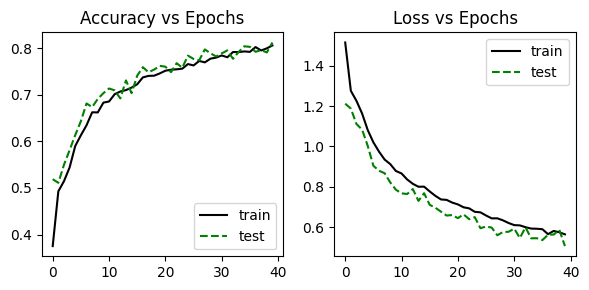

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
plot(ax1, train=stats['train_accuracies'], test=stats['test_accuracies'], title='Accuracy vs Epochs')
plot(ax2, train=stats['train_losses'], test=stats['test_losses'], title='Loss vs Epochs')
plt.tight_layout()
plt.show()

can also use the pred folder to do some predictions if needed